In [8]:
import pandas as pd
import numpy as np
import requests
import bs4
import json
import time
from random import randint
from tqdm import tqdm
import os.path
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TAGConv
import torch.nn as nn
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from scipy.signal import medfilt

In [7]:
def get_all_recipes():
    """
    Gets all the recipes into a dictionnary
    """
    item_files = [f for f in listdir('./data/TimeSeries') if isfile(join('./data/TimeSeries', f))] 
    ids = [item_file[:-5].split('_')[-1] for item_file in item_files]
    all_recipes = {}
    for item_id in tqdm(ids):
        raw_xml = load_item(item_id)
        all_recipes = {**all_recipes, **get_reagents_from_xml(raw_xml, item_id)}
    return all_recipes

def load_item(item_id):
    """
    Load an item from local or from WowHead API.
    """
    file_name = './data/item_{}.xml'.format(item_id)
    url = 'https://www.wowhead.com/item={}&xml'.format(item_id)
    if os.path.isfile(file_name):
        f = open(file_name, "r")
        raw_xml = f.read()
        f.close()
    else:
        print('Downloading item {}'.format(item_id))
        sleep(30)
        raw_xml = requests.get(url).text
        with open(file_name, 'w') as outfile:
            outfile.write(raw_xml)
    return raw_xml

def get_reagents_from_xml(raw_xml, item_id):
    """
    Get all reageants for all recipes of one item.
    """
    soup = BeautifulSoup(raw_xml, "lxml")
    level = int(soup.find('level').text)
    # Get item name
    name = soup.find('b', class_ = 'q1')
    if name is None:
        name = soup.find('b', class_ = 'q2')
    if name is None:
        name = soup.find('b', class_ = 'q3')
    name = name.text
    # Get each recipe (spell)
    createdby = soup.find('createdby')
    if createdby is None:
        return  {item_id: (name, [], level)}
    spells = createdby.find_all('spell')
    # Get each reagent in each recipe
    reagent_lists = [spell.find_all('reagent') for spell in spells]
    return {item_id: (name, reagent_lists, level)}

def merge_items_in_df():
    """
    Get all times series into one dataframe.
    """
    # Get all files from data
    item_files = [f for f in listdir('./data/TimeSeries') if isfile(join('./data/TimeSeries', f))]
    dataframes = []
    for item_file in tqdm(item_files):
        item_name = item_file[:-5].split('_')[-1]
        sub_df = get_df_from_file('./data/TimeSeries/' + item_file)
        if not sub_df is None:
            sub_df = sub_df.set_index('date')
            sub_df.columns = [el + '_' + str(item_name) for el in list(sub_df.columns)]
            dataframes.append(sub_df)
    return pd.concat(dataframes, axis=1)

def get_product_monthly_df(house, item):
    raw_json = get_product_raw_json(house, item)
    parsed_json = json.loads(raw_json)
    return transform_json_to_df(parsed_json)

def get_df_from_file(file):
    f = open(file, "r")
    content = f.read()
    f.close()
    return transform_json_to_df(json.loads(json.loads(content)))

def transform_json_to_df(parsed_json):
    if 'monthly' in parsed_json.keys():
        if type(parsed_json['monthly']) == list:
            return pd.DataFrame(parsed_json['monthly'][0])
        elif type(parsed_json['monthly']) == dict:
            return pd.DataFrame(parsed_json['monthly'][list(parsed_json['monthly'].keys())[0]])
    else:
        return None

def create_edge_index(all_recipes, ts_df_columns):
    source_target = set()
    for item_id in all_recipes.keys():
        if ('silver_' + item_id in ts_df_columns):
            value = all_recipes[item_id]
            level = value[2]
            reagents = set()
            if level > 110:
                for recipe in value[1]:
                    for reagent in recipe:
                        if ('silver_' + reagent['id'] in ts_df_columns):
                            reagents.add(reagent['id'])
                for reagent_id in reagents:
                    source_target.add((reagent_id, item_id))
                    source_target.add((item_id, reagent_id))
    source = [s_t[0] for s_t in source_target]
    target = [s_t[1] for s_t in source_target]
    return source, target

In [8]:
all_recipes = get_all_recipes()

100%|██████████| 145/145 [00:00<00:00, 493.78it/s]


In [9]:
# Time Series preparation
time_series_df = merge_items_in_df()

100%|██████████| 145/145 [00:01<00:00, 94.58it/s]


In [10]:
# Preparation of edge_index
source, target = create_edge_index(all_recipes, time_series_df.columns)
le = LabelEncoder()
le.fit(source)
prepared_source = le.transform(source)
prepared_target = le.transform(target)

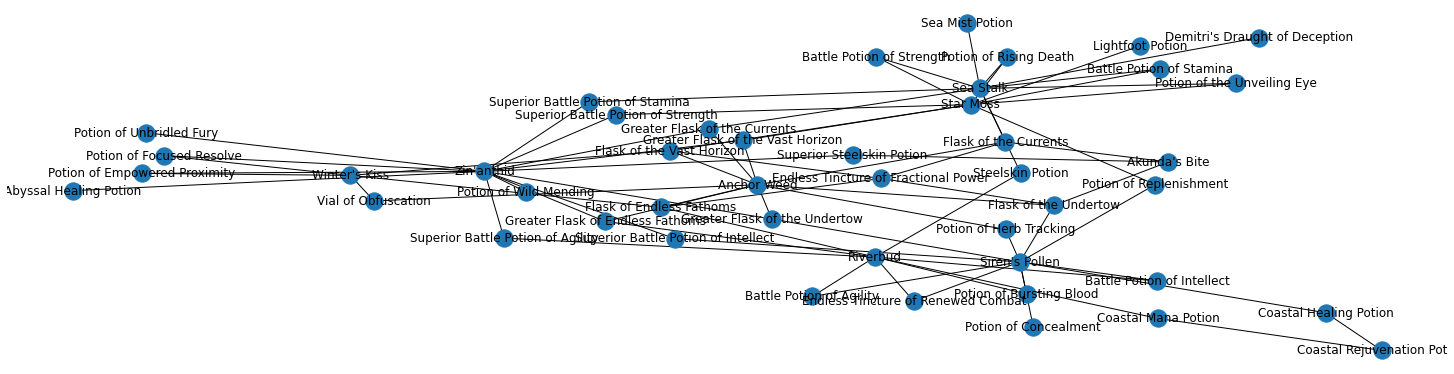

In [11]:
G = nx.Graph()
for s, t in zip(prepared_source, prepared_target):
    source_id, target_id = le.inverse_transform([s,t])
    source_name = all_recipes[str(source_id)][0]
    target_name = all_recipes[str(target_id)][0]
    G.add_edge(source_name,target_name)
plt.figure(figsize = (20,5))
nx.draw(G, with_labels=True)

In [35]:
# Time Series preparation
ordered_ids = le.inverse_transform(sorted(set(prepared_source)))
ordered_columns = ['silver_' + index for index in ordered_ids]
time_series_df = time_series_df[ordered_columns].dropna()
scaler = MinMaxScaler()
x = scaler.fit_transform(time_series_df).transpose()
# x = np.array([time_series_df[col].values for col in ordered_columns])
x = medfilt(x, 3)

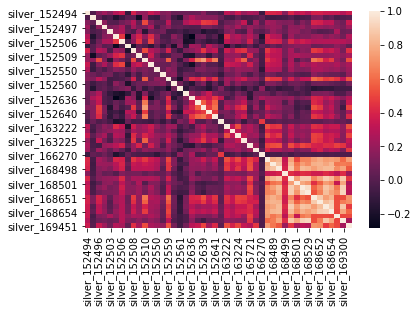

In [43]:
import seaborn as sns
sns.heatmap(time_series_df.corr())

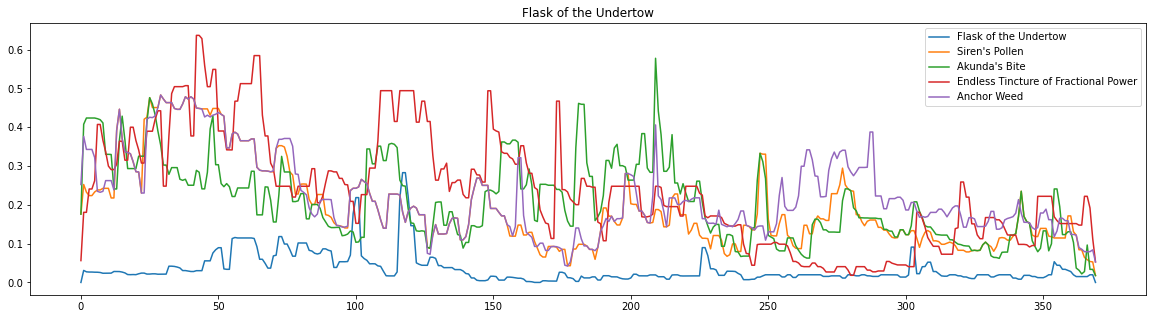

In [41]:
name2index = dict([(all_recipes[temp][0], index) for temp, index in zip(le.inverse_transform(sorted(set(prepared_source))), set(prepared_source))])
example_index = le.inverse_transform([22])[0]
example_name = all_recipes[str(example_index)][0]
neighbors = G.neighbors(example_name)
plt.figure(figsize = (20,5))
plt.plot(x[0,:], label=example_name)
for neighbor in neighbors:
    plt.plot(x[name2index[neighbor],:], label=neighbor)
plt.title(example_name)
plt.legend()
plt.show()

In [2]:
def create_batches(x, window_length):
    """
    Create batches of data for prediction.
    """
    n, m = x.shape
    batches_x = []
    batches_y = []
    for index in range(m - window_length - 1):
        batch_x = x[:, index: index + window_length]
        batch_y = x[:, index + window_length + 1]
        batches_x.append(np.array(batch_x))
        batches_y.append(np.array(batch_y))
    return np.array(batches_x), np.array(batches_y)

def create_input_data_batches(batches):
    tensor_batches = []
    for batch in batches:
        n, m = batch.shape
        tensor_batch = x = torch.tensor(batch, dtype=torch.float).view(n, 1, m)
        tensor_batches.append(tensor_batch)
    return tensor_batches    

In [3]:
batches_x, batches_y = create_batches(x, 13)
tensors_x = create_input_data_batches(batches_x)

NameError: name 'x' is not defined

In [5]:
epochs = 100
l, n, m = batches_x.shape 
model = STGCN(m, n, 1, time_conv_length=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
edge_index = torch.tensor([prepared_source,prepared_source], dtype=torch.long)

for i in range(epochs):
    for seq, labels in zip(tensors_x, batches_y):
        data = Data(x=seq, edge_index=edge_index)
        # optimizer.zero_grad()
        # model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
        #                 torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(data)
    
        labels = torch.tensor(labels, dtype=torch.float).view(-1, 1)
        single_loss = loss_function(y_pred.y, labels)
        single_loss.backward()
        optimizer.step()

    if i%3 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

NameError: name 'batches_x' is not defined